
# La methode CCN

Import des librairies 

In [3]:
pip install imgaug

     |████████████████████████████████| 948 kB 739 kB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 795 kB/s eta 0:00:01
     |████████████████████████████████| 40.3 MB 268 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

# Le Nombre de races et de photos

In [13]:
PATH = '/Users/test/Desktop/Cours/deep_learning/rendu_propre/images/Images'

In [9]:
os.listdir()

['.DS_Store',
 'NN_Sonar_data_NN_Sonar_data.ipynb',
 'images',
 'NN_Standford_dogs_classification_2_Custom_CNN.ipynb',
 'NN_Standford_dogs_classification_3_TransferLearning_InceptionV3.ipynb',
 'annotations',
 '.ipynb_checkpoints',
 'NN_Standford_dogs_classification_1_cropping.ipynb',
 'NN_Standford_dogs_classification_4_predictions.ipynb',
 'Projet indiv.ipynb']

In [14]:
os.getcwd()
os.chdir(PATH)
os.getcwd()

'/Users/test/Desktop/Cours/deep_learning/rendu_propre/images/Images'

In [37]:
breed_list = os.listdir("/Users/test/Desktop/Cours/deep_learning/rendu_propre/images/Images")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))
for breed in breed_list:
    n_total_images += len("/Users/test/Desktop/Cours/deep_learning/rendu_propre/images/Images/{}".format(breed))
print("{} images".format(n_total_images))

124 breeds
25370 images


# Configuration des données 

In [38]:
SIZE = 300
BATCH_SIZE = 64
CATEGORIES = os.listdir(PATH)

NUM_CLASES = len(CATEGORIES)

In [42]:
from keras.preprocessing.image import ImageDataGenerator

In [43]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255
)

In [44]:
training_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,  
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

training_generator = training_datagen.flow_from_directory(
    PATH,
    target_size=(SIZE,SIZE),
    batch_size=BATCH_SIZE,
    classes=CATEGORIES,
    class_mode='categorical',
    subset='training'
)

# configuration de  (test set)
# test_datagen = ImageDataGenerator(rescale=1./255)

# generador ()
test_generator = training_datagen.flow_from_directory(
        PATH,
        target_size=(SIZE,SIZE),
        batch_size=BATCH_SIZE//2,
        class_mode='categorical',
        subset='validation'
)

Found 16880 images belonging to 124 classes.
Found 4164 images belonging to 123 classes.


In [49]:
# Nombre de classes (120 races)
num_classes = len(training_generator.class_indices)

# Encodage des labels de l'échantillon de train
# Ressource : https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437
train_labels = training_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

# Encodage des labels de l'échantillon de validation
valid_labels = test_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

nb_train_samples = len(training_generator.filenames)  
nb_valid_samples = len(test_generator.filenames)

mappage de chaînes d'étiquettes et de nombres

In [50]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [73]:
label_maps

{'n02097658-silky_terrier': 0,
 'n02092002-Scottish_deerhound': 1,
 'n02099849-Chesapeake_Bay_retriever': 2,
 'n02091244-Ibizan_hound': 3,
 'n02095314-wire-haired_fox_terrier': 4,
 'n02091831-Saluki': 5,
 'n02102318-cocker_spaniel': 6,
 'n02104365-schipperke': 7,
 'n02090622-borzoi': 8,
 'n02113023-Pembroke': 9,
 'n02105505-komondor': 10,
 'n02093256-Staffordshire_bullterrier': 11,
 'n02113799-standard_poodle': 12,
 'n02109961-Eskimo_dog': 13,
 'n02089973-English_foxhound': 14,
 'n02099601-golden_retriever': 15,
 'n02095889-Sealyham_terrier': 16,
 'n02085782-Japanese_spaniel': 17,
 '.DS_Store': 18,
 'n02097047-miniature_schnauzer': 19,
 'n02110063-malamute': 20,
 'n02105162-malinois': 21,
 'n02086079-Pekinese': 22,
 'n02097130-giant_schnauzer': 23,
 'n02113978-Mexican_hairless': 24,
 'n02107142-Doberman': 25,
 'n02097209-standard_schnauzer': 26,
 'n02115913-dhole': 27,
 'n02106662-German_shepherd': 28,
 'n02106382-Bouvier_des_Flandres': 29,
 'n02110185-Siberian_husky': 30,
 'n02094258-

# Montrons quelques photos

In [51]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/Users/test/Desktop/Cours/deep_learning/rendu_propre/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02097658-silky_terrier


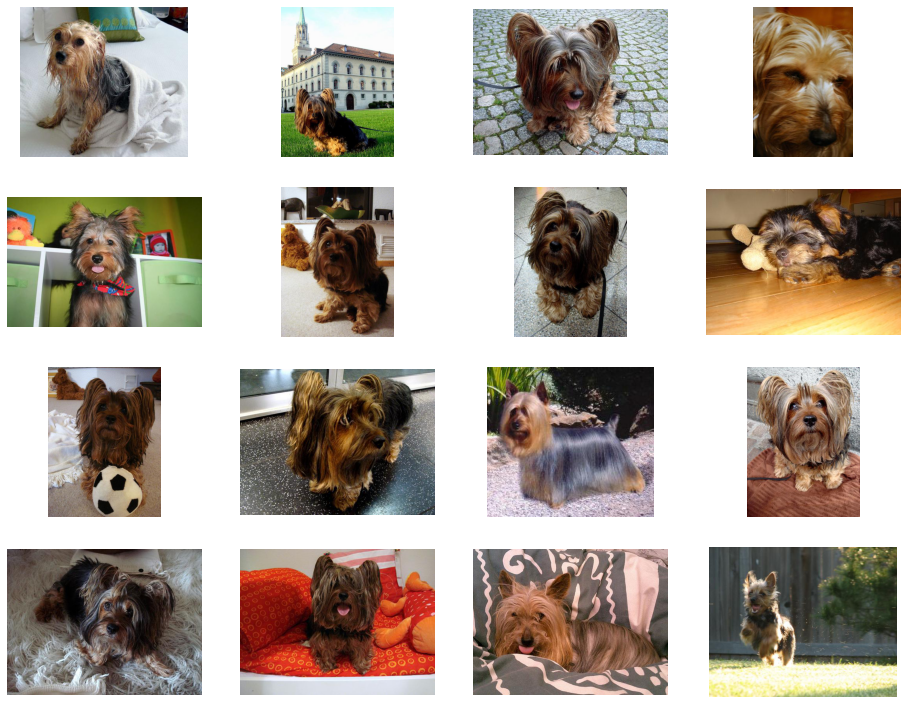

In [52]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

# Recadrons et enregistrons des images

In [62]:
%%time

# inspiré sur le site https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('/Users/test/Desktop/Cours/deep_learning/rendu_propre/annotations/Annotation/{}'.format(breed)):
        img = Image.open('/Users/test/Desktop/Cours/deep_learning/rendu_propre/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('/Users/test/Desktop/Cours/deep_learning/rendu_propre/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 124 folders to store cropped images of the different breeds.


NotADirectoryError: [Errno 20] Not a directory: '/Users/test/Desktop/Cours/deep_learning/rendu_propre/annotations/Annotation/.DS_Store'

# Préparation de notre X et de Y

In [64]:
from tensorflow.python.keras.utils import np_utils

In [65]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

# Génération d'images avec la data augmentation 

In [67]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

# train test split

In [83]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

Formons des couches 

In [80]:
for layer in model.layers[:]:
    layer.trainable = True

In [85]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [84]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [90]:
img_width, img_height = 150, 150
channels = 3
model = Sequential()

# Couche d'entrée
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(img_width, img_height, channels)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

# Couche sup
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

# Couche sup
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

# Couche sup
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))

# Couches connectées
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 150, 150, 16)      432       
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 150, 16)      48        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 38, 38, 32)        4608      
_________________________________________________________________
batch_normalization_21 (Batc (None, 38, 38, 32)       

In [91]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [92]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [ ]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20)

In [94]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

NameError: name 'history' is not defined

# Predicition

In [ ]:
def download_and_predict("https://dog.ceo/api/breeds/image/random", filename):
    # download and save
    os.system("curl -s {} -o {}".format("https://dog.ceo/api/breeds/image/random", filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

In [105]:
pip install requests

Note: you may need to restart the kernel to use updated packages.
